In [12]:
import pandas as pd
import numpy as np
import yaml

# Getting the Data from Config File

In [13]:
config = open("../configs.yaml", "r")
dictionary = yaml.safe_load(config)

In [14]:
# Data Loading Fields
GRADES_FILENAME = dictionary["data_path"]["grades_filename"]

# Lab Fields
NUM_LABS = dictionary["labs"]["num_labs"]
MAX_LABS = dictionary["labs"]["max_labs"]

# Project Fields
NUM_PROJECTS = dictionary["projects"]["num_projects"]
MAX_PROJECTS = dictionary["projects"]["max_projects"]

NUM_PROJECT_CHECKPOINTS = dictionary["projects"]["num_checkpoints"]
MAX_PROJECT_CHECKPOINTS = dictionary["projects"]["max_checkpoints"]

# Midterm fields
YES_MIDTERM = dictionary["exams"]["midterm"]["enabled"]
MIDTERM_VERSIONS = dictionary["exams"]["midterm"]["versions"]
MIDTERM_BONUS = dictionary["exams"]["midterm"]["bonus"]

# Final Fields
YES_FINAL = dictionary["exams"]["final"]["enabled"]
FINAL_VERSIONS = dictionary["exams"]["final"]["versions"]
FINAl_BONUS = dictionary["exams"]["final"]["bonus"]

# Discussion Fields
NUM_DISC_ATTENDENCE_REQUIRED = dictionary["discussions"][
    "num_discussions_attendence_required"
]
NUM_LECT_ATTENDENCE_REQUIRED = dictionary["discussions"][
    "num_lecture_attendence_required"
]

# Number of dropped assignments per category (set to 0 for no drops)
# For example, if NUM_DROPS = 2, then 2 Labs and 2 Homeworks will be dropped
# Note: Set this to 0 until the end of the quarter
NUM_DROPS = dictionary["drop_policy"]["num_drops"]

OVERALL_EC = dictionary["extra_credit"]["overall"]

ASSIGNMENT_WEIGHTS = dictionary["assignment_weights"]
DISCUSSION_ASSIGNMENT_WEIGHTS = dictionary["discussion_assignment_weights"]

# Late Submission Grace Period (3 Minutes)
GRACE_PERIOD = 3 / 60

# Reading in the Current Grade CSV

In [15]:
df = pd.read_csv(GRADES_FILENAME)
discussion_and_lecture_attendence = pd.read_csv("../data/attendance.csv").drop(
    columns=["Email", "Name"]
)
df = df.merge(discussion_and_lecture_attendence, how='left', on="SID").set_index("SID")

# Create name column if not already present
if "Name" not in df.columns:
    df["Name"] = df["First Name"] + " " + df["Last Name"]
    df = df.drop(["First Name", "Last Name"], axis=1)

In [16]:
df.query("Name == 'HAOYU GUO'")

,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Project 1 Checkpoint,Project 1 Checkpoint - Max Points,Project 1 Checkpoint - Submission Time,Project 1 Checkpoint - Lateness (H:M:S),...,Final Exam - Version A - Max Points,Final Exam - Version A - Submission Time,Final Exam - Version A - Lateness (H:M:S),Final Exam - Version B,Final Exam - Version B - Max Points,Final Exam - Version B - Submission Time,Final Exam - Version B - Lateness (H:M:S),Total Lateness (H:M:S),disc_count,lecture_count
SID,,,,,,,,,,,,,,,,,,,,,
U10131161,HAOYU GUO,ax009353@acsmail.ucsd.edu,110.0,133.0,2024-04-10 21:47:36 -0700,00:00:00,13.0,13.0,2024-04-12 22:20:02 -0700,00:00:00,...,100.0,2024-06-08 11:53:00 -0700,00:00:00,NaN,100.0,NaN,00:00:00,63:25:49,NaN,NaN


# Lab 1 Does not have Redemption Assignement 

In [17]:
# At the beginning of the quarter, we did not do Lab 1 Redemption
def redemption_score(lateness, score):
    if lateness != "00:00:00":
        return score
    else:
        return np.nan


df["Lab 1 Redemption"] = df.apply(
    lambda row: redemption_score(row["Lab 1 - Lateness (H:M:S)"], row["Lab 1"]), axis=1
)
df["Lab 1 Redemption - Max Points"] = df["Lab 1 - Max Points"]

# Fixing few Labs and Projects we did Manual Grading for

In [18]:
df["Lab 9 - Max Points"] /= 2
df["Project 3 Redemption - Max Points"] /= 2

# Fixing the Final Projects

In [19]:
df["Project 4"] = df[
    [
        "Project 4 Notebook PDF (Power Outages)",
        "Project 4 Notebook PDF (League of Legends)",
        "Project 4 Notebook PDF (Recipes and Ratings)",
    ]
].sum(axis=1)

df["Project 4 - Max Points"] = df["Project 4 Notebook PDF (Power Outages) - Max Points"]

df["Project 4 Checkpoint"] = df["Final Project (Checkpoint1)"]
df["Project 4 Checkpoint - Max Points"] = df["Final Project (Checkpoint1) - Max Points"]

df["Project 5 Checkpoint"] = df["Final Project (Checkpoint2)"]
df["Project 5 Checkpoint - Max Points"] = df["Final Project (Checkpoint2) - Max Points"]

# Calculating the Grade for each Assignment

In [20]:
def get_assignment_grade(r, assignment_name):
    num = r[assignment_name]
    den = r[assignment_name + " - Max Points"]

    return num / den

In [21]:
for i in range(1, NUM_LABS + 1):
    assignment_name = f"Lab {i}"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )
    # if i == 1:
    #     pass

    assignment_name = f"Lab {i} Redemption"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

In [22]:
for i in range(1, NUM_PROJECTS + 1):
    assignment_name = f"Project {i}"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

    # 4th project has no redemption
    if i == 4:
        break
    assignment_name = f"Project {i} Redemption"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

In [23]:
for i in range(1, NUM_PROJECT_CHECKPOINTS + 1):
    assignment_name = f"Project {i} Checkpoint"
    df[assignment_name + " Final Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

# Calculating Final Grade with Redemption Assignments

In [24]:
def final_grade_with_redemption(assignment_name):
    df[f"{assignment_name} Final Grade"] = df[f"{assignment_name} Grade"] + (
        (
            df[f"{assignment_name} Redemption Grade"] - df[f"{assignment_name} Grade"]
        ).apply(lambda x: x if x > 0 else 0)
        * 0.8
    ).fillna(0)

In [25]:
# As Project 4 has no redemption, we will calculate the final grade without redemption
redemptions_assignments = [f"Project {i+1}" for i in range(0, NUM_PROJECTS - 1)] + [
    f"Lab {i+1}" for i in range(0, NUM_LABS)
]
for assignment in redemptions_assignments:
    final_grade_with_redemption(assignment)
df["Project 4 Final Grade"] = df["Project 4 Grade"]

# Finding Dropped Lab

In [26]:
def find_dropped_labs(df):
    lab_scores = df[[f"Lab {i} Final Grade" for i in range(1, NUM_LABS + 1)]].fillna(0)
    dropped_labs = np.argsort(np.array(lab_scores))[:NUM_DROPS]
    dropped_labs = np.sort(dropped_labs) + 1
    dropped_labs = [f"Lab {l}" for l in dropped_labs]
    return ", ".join(dropped_labs)


df["Dropped Labs"] = df.apply(find_dropped_labs, axis=1)

# Calculating Midterm and Final Grades

In [27]:
def individual_student_redemption(row):
    if row["Redemption Successful"]:
        post_redemption = (
            row["Midterm Redemption Z-Score"] * row["Midterm std"] + row["Midterm Mean"]
        )
        return np.clip(post_redemption, 0, 1)
    else:
        return row["Midterm Exam Grade"]

In [28]:
if YES_MIDTERM:
    df["Midterm Exam Grade"] = df["Midterm"] / df["Midterm - Max Points"]
    df["Midterm Mean"] = df["Midterm Exam Grade"].dropna().mean()
    df["Midterm std"] = df["Midterm Exam Grade"].dropna().std(ddof=0)
    df["Midterm Z-Score"] = (df["Midterm Exam Grade"] - df["Midterm Mean"]) / df[
        "Midterm std"
    ]
    if YES_FINAL:
        MIDTERM_REDEMPTION_MAX_POINTS = 32
        for version in FINAL_VERSIONS:
            cur_version_final = pd.read_csv(
                f"../data/Final_Exam_Version_Set_Scores/Final_Exam_-_Version_{version}_scores.csv"
            ).set_index("SID")
            redmp_questions = cur_version_final.columns[
                cur_version_final.columns.str.contains(r"\(M\)")
            ]
            redmp_scores = cur_version_final[redmp_questions].sum(axis=1)
            redmp_scores = redmp_scores[~redmp_scores.index.duplicated()]
            # merge the redemp_scores with df
            df = df.assign(
                **{f"redepmtion_v{version}": redmp_scores},
                left_index=True,
                right_index=True,
            )
        df["Redemption Score"] = df[
            [f"redepmtion_v{version}" for version in FINAL_VERSIONS]
        ].sum(axis=1)
        df["Midterm Redemption Mean"] = df["Redemption Score"].dropna().mean()
        df["Midterm Redemption std"] = df["Redemption Score"].dropna().std(ddof=0)
        df["Midterm Redemption Z-Score"] = (
            df["Redemption Score"] - df["Midterm Redemption Mean"]
        ) / df["Midterm Redemption std"]
        df["Redemption Successful"] = (
            df["Midterm Redemption Z-Score"] > df["Midterm Z-Score"]
        )
        df["Midterm Exam Grade Post-Redemption"] = df.apply(
            individual_student_redemption, axis=1
        )

    else:
        df["Midterm Exam Grade Post-Redemption"] = df["Midterm Exam Grade"]

In [29]:
if YES_FINAL:
    df["Final Exam"] = 0
    df["Final Exam - Max Points"] = df["Final Exam - Version A - Max Points"].max()
    for version in FINAL_VERSIONS:
        df["Final Exam"] += df[f"Final Exam - Version {version}"].fillna(0)
    df["Final Exam Grade"] = df["Final Exam"] / df["Final Exam - Max Points"]

# Finding Students who are eligible for Discussion Section

In [30]:
df["Elgible for Discussion"] = (df["disc_count"] >= NUM_DISC_ATTENDENCE_REQUIRED) & (
    df["lecture_count"] >= NUM_LECT_ATTENDENCE_REQUIRED
)

# Calculating the Maximum Possible Grade Right Now 

In [31]:
df["Max Possible Points"] = (
    NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + NUM_PROJECTS / MAX_PROJECTS * ASSIGNMENT_WEIGHTS["project"]
    + NUM_PROJECT_CHECKPOINTS
    / MAX_PROJECT_CHECKPOINTS
    * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Max Possible Points"] += ASSIGNMENT_WEIGHTS["midterm_exam"]
if YES_FINAL:
    df["Max Possible Points"] += ASSIGNMENT_WEIGHTS["final_exam"]
df["Max Possible Points"] *= 100
df["Current Max Possible Score"] = df["Max Possible Points"].max()
df["Current Max Possible Score"].max()

100.0

In [32]:
df.fillna(0, inplace=True)

# Calculating Average Score for Each Assignment Group

## 1 Lab is Dropped

In [33]:
def calculate_lab_mean(row):
    exclude_col = row["Dropped Labs"]
    exclude_col += " Final Grade"
    lab_columns = [f"Lab {i+1} Final Grade" for i in range(0, NUM_LABS)]
    columns_to_include = [
        col for col in lab_columns if col not in [exclude_col, "Exclude"]
    ]
    row_mean = row[columns_to_include].fillna(0).mean()
    return row_mean

In [34]:
Final_Project_Grade = [f"Project {i+1} Final Grade" for i in range(0, NUM_PROJECTS)]
# We are adding Final Project 4 Grade to the list of Final Project Grades twice because it has double weight
Final_Project_Grade.append("Project 4 Final Grade")
Final_Project_Checkpoint_Grade = [
    f"Project {i+1} Checkpoint Final Grade" for i in range(0, NUM_PROJECT_CHECKPOINTS)
]

df["Lab Average"] = df.apply(calculate_lab_mean, axis=1)
df["Project Average"] = df[Final_Project_Grade].fillna(0).mean(axis=1)
df["Project Checkpoint Average"] = (
    df[Final_Project_Checkpoint_Grade].fillna(0).mean(axis=1)
)
if YES_MIDTERM:
    df["Midterm Average"] = df["Midterm Exam Grade Post-Redemption"]
if YES_FINAL:
    df["Final Average"] = df["Final Exam Grade"]

# Claculating Scores for Each Student Without Discussion

In [37]:
df["Overall Score without Discussion"] = (
    df["Lab Average"] * NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + df["Project Average"] * NUM_PROJECTS / MAX_PROJECTS * ASSIGNMENT_WEIGHTS["project"]
    + df["Project Checkpoint Average"] * NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Overall Score without Discussion"] += (
        df["Midterm Average"] * ASSIGNMENT_WEIGHTS["midterm_exam"]
    )
if YES_FINAL:
    df["Overall Score without Discussion"] += (
        df["Final Average"] * ASSIGNMENT_WEIGHTS["final_exam"]
    )

df["Overall Score without Discussion"] *= 100

df["Overall Score without Discussion"].max()

93.33447344903735

# Claculating Scores for Each Student With Discussion

In [38]:
df["Overall Score with Discussion"] = (
    df["Lab Average"] * NUM_LABS / MAX_LABS * DISCUSSION_ASSIGNMENT_WEIGHTS["lab"]
    + df["Project Average"] * NUM_PROJECTS / MAX_PROJECTS * DISCUSSION_ASSIGNMENT_WEIGHTS["project"]
    + df["Project Checkpoint Average"] * NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS * DISCUSSION_ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Overall Score with Discussion"] += (
        df["Midterm Average"] * DISCUSSION_ASSIGNMENT_WEIGHTS["midterm_exam"]
    )
if YES_FINAL:
    df["Overall Score with Discussion"] += (
        df["Final Average"] * DISCUSSION_ASSIGNMENT_WEIGHTS["final_exam"]
    )

df["Overall Score with Discussion"] += DISCUSSION_ASSIGNMENT_WEIGHTS["discussion"]

df["Overall Score with Discussion"] *= 100
df["Overall Score with Discussion"].max()

94.00947344903734

# Finding Current Overall Score

In [39]:
df['Used Discussion'] = df["Overall Score with Discussion"] * df["Elgible for Discussion"] > df["Overall Score without Discussion"] 

df["Overall Score"] = df.apply(
    lambda row: max(
        row["Overall Score with Discussion"] * row["Elgible for Discussion"],
        row["Overall Score without Discussion"],
    ),
    axis=1,
)

# Calculating Current Grade(Percent / Total Point Possible) for Each Student

In [40]:
df["Current Score"] = df["Overall Score"] / df["Max Possible Points"] * 100

In [41]:
df.reset_index(inplace=True)

<AxesSubplot:>

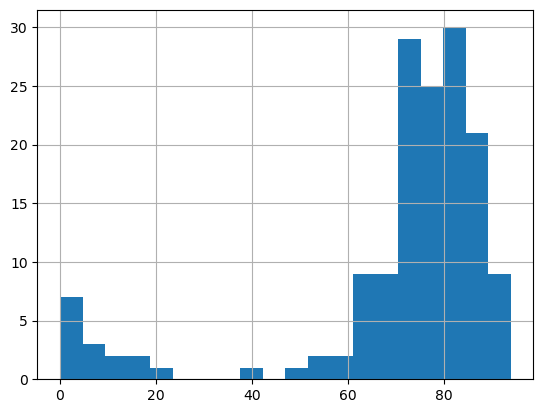

In [42]:
df["Current Score"].hist(bins=20)

In [47]:
df = df.sort_values("Overall Score", ascending=False)
df = df.drop_duplicates(subset='SID', keep='first')
df

,SID,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Project 1 Checkpoint,Project 1 Checkpoint - Max Points,Project 1 Checkpoint - Submission Time,...,Lab Average,Project Average,Project Checkpoint Average,Midterm Average,Final Average,Overall Score without Discussion,Overall Score with Discussion,Used Discussion,Overall Score,Current Score
109,A17372175,Rita Yujia Wu,yuw172@ucsd.edu,133.0,133.0,2024-04-24 14:33:56 -0700,326:34:56,13.0,13.0,2024-04-12 17:53:04 -0700,...,0.999035,0.978151,1.000,0.80,0.930,93.334473,94.009473,True,94.009473,94.009473
139,A17466227,Yolanda Feng,yuf019@ucsd.edu,133.0,133.0,2024-05-21 22:20:03 -0700,982:21:03,13.0,13.0,2024-04-12 17:53:04 -0700,...,1.008257,0.978151,1.000,0.76,0.930,92.718931,93.493931,True,93.493931,93.493931
68,A18137549,Jefferson Chen,jec068@ucsd.edu,133.0,133.0,2024-05-08 19:56:02 -0700,667:57:02,13.0,13.0,2024-04-11 15:16:36 -0700,...,0.989007,0.968133,1.000,0.80,0.855,90.633450,91.495950,True,91.495950,91.495950
134,A18078140,Viv Somani,visomani@ucsd.edu,132.0,133.0,2024-04-05 14:20:13 -0700,00:00:00,13.0,13.0,2024-04-09 16:59:03 -0700,...,0.959407,0.964075,0.975,0.78,0.900,90.765000,91.565000,False,90.765000,90.765000
90,A17275989,Matt Tokunaga,m2tokunaga@ucsd.edu,133.0,133.0,2024-06-07 01:07:31 -0700,1369:08:31,13.0,13.0,2024-04-08 21:31:47 -0700,...,0.988243,0.992000,1.000,0.82,0.815,90.414869,91.327369,False,90.414869,90.414869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,A17404977,Kristina Nguyen,krn002@ucsd.edu,126.0,133.0,2024-04-10 21:55:18 -0700,00:00:00,0.0,13.0,0,...,0.118421,0.000000,0.000,0.00,0.000,2.368421,7.368421,False,2.368421,2.368421
12,U10042056,Antoine CARRE CARRE,ax009221@acsmail.ucsd.edu,115.0,133.0,2024-04-10 19:27:47 -0700,00:00:00,0.0,13.0,0,...,0.108083,0.000000,0.000,0.00,0.000,2.161654,7.161654,False,2.161654,2.161654
23,A16371195,Cariappa Kodira,ckodira@ucsd.edu,98.0,133.0,2024-04-16 16:14:07 -0700,136:15:07,0.0,13.0,2024-04-12 23:54:33 -0700,...,0.092105,0.000000,0.000,0.00,0.000,1.842105,6.842105,False,1.842105,1.842105
132,A17401622,Vinson Nguyen,vqn002@ucsd.edu,0.0,133.0,0,00:00:00,0.0,13.0,2024-04-12 21:39:15 -0700,...,0.000000,0.007921,0.000,0.00,0.000,0.198020,5.198020,False,0.198020,0.198020


In [48]:
df.to_csv("../data/grades_for_grade_report.csv", index=False)

In [49]:
df[
    [
        "Name",
        "Email",
        "SID",
        "Overall Score",
        "Lab Average",
        "Project Average",
        "Project Checkpoint Average",
        "Midterm Average",
        "Final Average",
        "lecture_count",
        "disc_count",
        "Overall Score without Discussion",
        "Overall Score with Discussion",
        "Used Discussion",
    ]
].to_csv("../to_sam.csv", index=False)